In [1]:
'''
Load obstacles from Matlab, define RRT and RRT*, visualize a path, and convert to 
waypoints for backend. Contains helper functions for path length etc.

MIT License
Copyright (c) 2019 Fanjin Zeng
This work is licensed under the terms of the MIT license, see <https://opensource.org/licenses/MIT>.  
https://gist.github.com/Fnjn/58e5eaa27a3dc004c3526ea82a92de80
RRT = rapidly exploring random tree
'''

import numpy as np
from random import random
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from collections import deque
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import ipympl
import math
import haversine as hs
%matplotlib widget

ModuleNotFoundError: No module named 'haversine'

In [44]:
# 3D version in progress
def dijkstra(G):
    '''
    Dijkstra algorithm for finding shortest path from start position to end.
    '''
    srcIdx = G.vex2idx[G.startpos]
    dstIdx = G.vex2idx[G.endpos]

    # build dijkstra
    nodes = list(G.neighbors.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in G.neighbors[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(G.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(G.vertices[curNode])
    return list(path)

class Line():
    ''' Define line '''
    def __init__(self, p0, p1):
        self.p = np.array(p0)
        self.dirn = np.array(p1) - np.array(p0)
        self.dist = np.linalg.norm(self.dirn)
        self.dirn /= self.dist # normalize

    def path(self, t):
        return self.p + t * self.dirn


def Intersection(line, center, radius):
    ''' Check line-sphere (circle) intersection '''
    a = np.dot(line.dirn, line.dirn)
    b = 2 * np.dot(line.dirn, line.p - center)
    c = np.dot(line.p - center, line.p - center) - radius * radius

    discriminant = b * b - 4 * a * c
    if discriminant < 0:
        return False

    t1 = (-b + np.sqrt(discriminant)) / (2 * a);
    t2 = (-b - np.sqrt(discriminant)) / (2 * a);

    if (t1 < 0 and t2 < 0) or (t1 > line.dist and t2 > line.dist):
        return False

    return True


def distance(obj1, obj2):
    return np.linalg.norm(np.array(obj1) - np.array(obj2))


def isInObstacle(vex, obstacles, radius):
    for obs in obstacles:
        if distance(obs, vex) < radius:
            return True
    return False


def isThruObstacle(line, obstacles, radius):
    for obs in obstacles:
        if Intersection(line, obs, radius):
            return True
    return False


def nearest(G, vex, obstacles, radius):
    Nvex = None
    Nidx = None
    minDist = float("inf")

    for idx, v in enumerate(G.vertices):
        line = Line(v, vex)
        if isThruObstacle(line, obstacles, radius):
            continue

        dist = distance(v, vex)
        if dist < minDist:
            minDist = dist
            Nidx = idx
            Nvex = v

    return Nvex, Nidx


def newVertex(randvex, nearvex, stepSize):
    dirn = np.array(randvex) - np.array(nearvex)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (stepSize, length)

    newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1], nearvex[2] + dirn[2])
    return newvex


def window(startpos, endpos):
    ''' Define seach window - 2 times of start to end rectangle'''
    width = endpos[0] - startpos[0]
    height = endpos[1] - startpos[1]
    winx = startpos[0] - (width / 2.)
    winy = startpos[1] - (height / 2.)
    return winx, winy, width, height


def isInWindow(pos, winx, winy, width, height):
    ''' Restrict new vertex insides search window'''
    if winx < pos[0] < winx+width and \
        winy < pos[1] < winy+height:
        return True
    else:
        return False


class Graph:
    ''' Define graph '''
    def __init__(self, startpos, endpos):
        self.startpos = startpos
        self.endpos = endpos

        self.vertices = [startpos]
        self.edges = []
        self.success = False

        self.vex2idx = {startpos:0}
        self.neighbors = {0:[]}
        self.distances = {0:0.}

        self.sx = endpos[0] - startpos[0]
        self.sy = endpos[1] - startpos[1]
        self.sz = endpos[2] - startpos[2]

    def add_vex(self, pos):
        try:
            idx = self.vex2idx[pos]
        except:
            idx = len(self.vertices)
            self.vertices.append(pos)
            self.vex2idx[pos] = idx
            self.neighbors[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2))
        self.neighbors[idx1].append((idx2, cost))
        self.neighbors[idx2].append((idx1, cost))


    def randomPosition(self):
        rx = random()
        ry = random()
        rz = random()

        posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
        posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
        posz = self.startpos[2] - (self.sz / 2.) + rz * self.sz * 2
        return posx, posy, posz


def RRT(startpos, endpos, obstacles, n_iter, radius, stepSize):
    ''' RRT algorithm '''
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            G.success = True
            #print('success')
            # break
    return G


def RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize):
    ''' RRT star algorithm '''
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)
        G.distances[newidx] = G.distances[nearidx] + dist

        # update nearby vertices distance (if shorter)
        for vex in G.vertices:
            if vex == newvex:
                continue

            dist = distance(vex, newvex)
            if dist > radius:
                continue

            line = Line(vex, newvex)
            if isThruObstacle(line, obstacles, radius):
                continue

            idx = G.vex2idx[vex]
            if G.distances[newidx] + dist < G.distances[idx]:
                G.add_edge(idx, newidx, dist)
                G.distances[idx] = G.distances[newidx] + dist

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            try:
                G.distances[endidx] = min(G.distances[endidx], G.distances[newidx]+dist)
            except:
                G.distances[endidx] = G.distances[newidx]+dist

            G.success = True
            #print('success')
            # break
    return G


def plt_sphere(list_center, list_radius, ax):
    for c, r in zip(list_center, list_radius):
        # draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x = r*np.cos(u)*np.sin(v)
        y = r*np.sin(u)*np.sin(v)
        z = r*np.cos(v)
        ax.plot_surface(c[0] - x, c[1] - y, c[2] - z, color="red")


def plot(G, obstacles, radius, path=None):
    '''
    Plot RRT, obstacles and shortest path. obstacles are 4d stuff
    '''
    plt.close()
    px = [x for x, y, z in G.vertices]
    py = [y for x, y, z in G.vertices]
    pz = [z for x, y, z in G.vertices]
    ax = plt.axes(projection='3d')
    #fig, ax = plt.subplots()

    #for obs in obstacles:
        #circle = plt.Circle(obs, radius, color='red')
        #ax.add_artist(circle)
        #ax.scatter3D(obs[0], obs[1], obs[2], c="red", s=radius)
    plt_sphere(obstacles, [radius]*len(obstacles), ax)

    ax.scatter3D(px, py, pz, c='cyan')
    ax.scatter3D(G.startpos[0], G.startpos[1], G.startpos[2], c='black')
    ax.scatter3D(G.endpos[0], G.endpos[1], G.endpos[2], c='black')

    lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
    print(G.edges)
    #lc = mc.LineCollection(lines, colors='green', linewidths=2)
    lc = Line3DCollection(lines, colors='green', linewidths=2)
    ax.add_collection(lc)

    if path is not None:
        paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
        #lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
        lc2 = Line3DCollection(paths, colors='blue', linewidths=3)
        ax.add_collection(lc2)

    ax.autoscale()
    ax.margins(0.1)
    plt.show()


def pathSearch(startpos, endpos, obstacles, n_iter, radius, stepSize):
    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    if G.success:
        path = dijkstra(G)
        # plot(G, obstacles, radius, path)
        return path

[(0.0, 0.0, 0.0), (0.5987125311128788, 0.32965756103850685, -0.15122565106010646), (0.7620203560133373, 0.90172120214605, 0.21765609808053774), (1.1855049016048884, 1.4498928046396837, 0.11681595793446867), (1.7606472162399247, 1.818734160815364, -0.03539235948195152), (1.8828020936292142, 2.2407414718914946, 0.5095737085702725), (2.377369152571769, 1.8409940895313486, 0.8021578067456905), (2.7401317540123618, 2.2085580920659864, 1.2747040997549262), (3.383870575024554, 2.054122506194822, 1.0472178800877505), (3.7145939248501993, 1.6953743904538128, 1.5491360560212182), (3.7006803105495334, 2.035426565924193, 2.160831183756395), (4.033480568580012, 2.6306365496907116, 2.3188472066132775), (4.184303875568965, 3.1947651061219946, 2.704867027202419), (4.321594571972597, 3.5904093007702156, 3.2657742708017206), (4.490416368276636, 3.5167829422397094, 3.941110009839879), (4.932097486874151, 3.2827434406390172, 4.431154192710104), (5.3254160709892755, 3.7232901279977617, 4.80694550134684), (

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
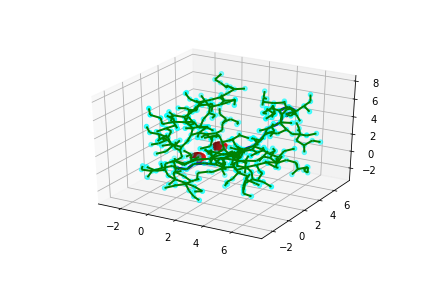

In [45]:
# 3D version in progress
if __name__ == '__main__':
    startpos = (0., 0., 0.)
    endpos = (5., 5., 5.)
    obstacles = [(1., 1., 1.), (2., 2., 2.)]

    n_iter = 400
    radius = 0.5
    stepSize = 0.7

    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    # G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

    if G.success:
        path = dijkstra(G)
        print(path)
        plot(G, obstacles, radius, path)
    else:
        print("No path")
        plot(G, obstacles, radius)
        

In [46]:
#4D version 
def newVertex(randvex, nearvex, stepSize):
    dirn = np.array(randvex) - np.array(nearvex)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (stepSize, length)

    newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1], nearvex[2] + dirn[2], nearvex[3] + dirn[3])
    return newvex
# increased constraints
def window(startpos, endpos):
    ''' Define seach window - 2 times of start to end rectangle'''
    width = endpos[0] - startpos[0]
    height = endpos[1] - startpos[1]
    length = endpos[2] - startpos[2]
    winx = startpos[0] - (width / 2.)
    winy = startpos[1] - (height / 2.)
    winz =  startpos[2] - (length / 2.)
    return winx, winy, winz, width, height, length


def isInWindow(pos, winx, winy, winz, width, height, length):
    ''' Restrict new vertex insides search window'''
    if winx < pos[0] < winx+width and \
        winy < pos[1] < winy+height and \
            winz < pos[2] < winz+length:
        return True
    else:
        return False


class Graph:
    ''' Define graph '''
    def __init__(self, startpos, endpos):
        self.startpos = startpos
        self.endpos = endpos

        self.vertices = [startpos]
        self.edges = []
        self.success = False

        self.vex2idx = {startpos:0}
        self.neighbors = {0:[]}
        self.distances = {0:0.}

        self.sx = endpos[0] - startpos[0]
        self.sy = endpos[1] - startpos[1]
        self.sz = endpos[2] - startpos[2]
        self.sw = endpos[3] - startpos[3] #added w

    def add_vex(self, pos):
        try:
            idx = self.vex2idx[pos]
        except:
            idx = len(self.vertices)
            self.vertices.append(pos)
            self.vex2idx[pos] = idx
            self.neighbors[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2))
        self.neighbors[idx1].append((idx2, cost))
        self.neighbors[idx2].append((idx1, cost))


    def randomPosition(self):
        rx = random()
        ry = random()
        rz = random()
        rw = random()

        posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
        posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
        posz = self.startpos[2] - (self.sz / 2.) + rz * self.sz * 2
        posw = self.startpos[3] - (self.sw / 2.) + rw * self.sw * 2
        return posx, posy, posz, posw


def plt_sphere(list_center, list_radius, ax):
    for c, r in zip(list_center, list_radius):
        # draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x = r*np.cos(u)*np.sin(v)
        y = r*np.sin(u)*np.sin(v)
        z = r*np.cos(v)
        ax.plot_surface(c[0] - x, c[1] - y, c[2] - z, color="red")


def plot(G, obstacles, radius, path=None):
    '''
    Plot RRT, obstacles and shortest path
    '''
    plt.close()
    fig = plt.figure(figsize=(8, 10))
    fig.add_subplot(211)
#     px = [x for x, y, z,w in G.vertices]
#     py = [y for x, y, z,w in G.vertices]
#     pz = [z for x, y, z,w in G.vertices]
    
    
    ax = plt.axes(projection='3d')
    
    plt_sphere([obs[:3] for obs in obstacles], [radius]*len(obstacles), ax)
    
#     ax.scatter3D(px, py, pz, c='cyan')
    ax.scatter3D(G.startpos[0], G.startpos[1], G.startpos[2], c='black')
    ax.scatter3D(G.endpos[0], G.endpos[1], G.endpos[2], c='black')
    
#     lines = [(G.vertices[edge[0]][:3], G.vertices[edge[1]][:3]) for edge in G.edges]
#      #lc = mc.LineCollection(lines, colors='green', linewidths=2)
#     lc = Line3DCollection(lines, colors='green', linewidths=2)
#     ax.add_collection(lc)

    if path is not None:
        paths = [(path[i][:3], path[i+1][:3]) for i in range(len(path)-1)]
        #lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
        lc2 = Line3DCollection(paths, colors='blue', linewidths=3)
        ax.add_collection(lc2)

    #ax.autoscale()
    ax.margins(0.2)
    
    fig.add_subplot(212)
    plt.plot([w for x, y, z,w in path])
    plt.subplots_adjust(hspace = 5)
    plt.xlabel('timestep')
    plt.ylabel('yaw')
    plt.show()

In [47]:
def smoothPath(path, obstacles, radius):
  """Smooths the given path by removing unnecessary intermediary nodes"""
  if len(path) < 3:
    return path
  leftPointer = 0
  rightPointer = 2
  while rightPointer <= len(path) - 1:
    line = Line(path[leftPointer], path[rightPointer])
    if not isThruObstacle(line, obstacles, radius):
      path.remove(path[leftPointer + 1])
    else:
      leftPointer += 1
      rightPointer += 1
  return path

[(0.0, 0.0, 0.0, 90.0), (1.2315877075241823, 1.7314416817796716, -0.20803215017150162, 87.58738405066447), (5.0, 5.0, 5.0, 85.0)]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
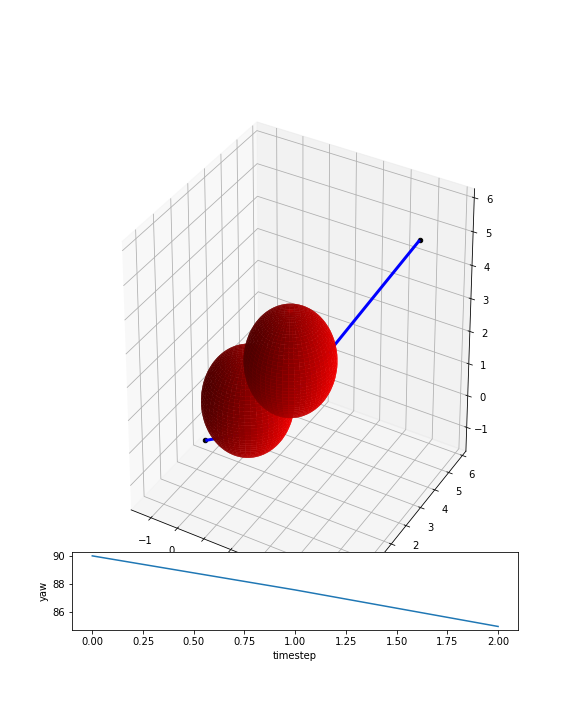

In [48]:
if __name__ == '__main__':
    startpos = (0., 0., 0., 90.) # define things for search
    endpos = (5., 5., 5., 85.)
    obstacles = [(1., 1., 1., 90.), (2., 2., 2.,90.)]
    n_iter = 800
    radius = 1.5
    stepSize = 0.7

    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    # G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

    if G.success:
        path = dijkstra(G)
        path = smoothPath(path, obstacles, radius)
        print(path)
        plot(G, obstacles, radius, path)
    else:
        print("No path")
        plot(G, obstacles, radius)
        

When stepsize approaches a significant fraction of total distance (1/8), performance starts to suffer. Least runtime solution that is still decent: n_iter=230,stepsize=4.

In [49]:
from itertools import starmap
def length_4D(path):
        pure_p = [p[:3] for p in path]
        pairs=zip(pure_p, pure_p[1:])
        return sum(starmap(distance,pairs))

def distance_4D(p1, p2):
    # calculates distance between two given points p1 and p2
    return math.sqrt((p1.sx-p2.sx)**2 + (p1.sy-p2.sy)**2 + (p1.sz-p2.sz)**2)

In [50]:
length_4D(path)

9.34659915148346

In [51]:
def path_to_waypoint(path):
    wp = []
    for node in path:
        new_waypoint = {'frame': MavrosDrone.FRAME_REFERENCE.RELATIVE_ALT.value,
                            'command': MavrosDrone.MAV_CMD.NAVIGATE_TO_WAYPOINT.value,
                            'is_current': False, 'autocontinue': True, 'param1': 0,
                            'param2': 0, 'param3': 0, 'x_lat': node[0],
                            'y_long': node[1],
                            'z_alt': node[2]}
        wp.append(new_waypoint)
    return wp

In [52]:
def getLatLong(oldLat, oldLong, dx, dy):
  # Returns the new latitude and longitude from offseting dx and dy meters from the old latitude and longitude
  # Radius of the earth is approximately 6371007 m
  # number of km per degree = ~111km (111.32 in google maps, but range varies
  # between 110.567km at the equator and 111.699km at the poles)
  # 1km in degree = 1 / 111.32km = 0.0089
  # 1m in degree = 0.0089 / 1000 = 0.0000089
  degreeOffset = dy * 0.0000089;
  newLat = oldLat + degreeOffset
  # pi / 180 = 0.018
  newLong = oldLong + degreeOffset / math.cos(oldLat * 0.018)
  trueDist = math.sqrt(dx ** 2 + dy ** 2)
  haversineDist = hs.haversine((oldLat, oldLong), (newLat, newLong)) * 1000
  if abs(haversineDist - trueDist) > 1:
    print(trueDist)
    print(haversineDist)
    print("Error is greater than 1 meter")
  return (newLat, newLong)